# Учебный Проект → «Чётенькое такси» 🚖

> Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

<hr>

Импортируем библиотеки 🎒

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import RandomState

from matplotlib import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
            }

In [4]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Константы.

In [5]:
RANDOM_SEED = 108108108
RANDOM_NP = RandomState(128)

Функции.

<hr>

## Загрузим данные

In [6]:
try:
    taxi_df = pd.read_csv(
        './datasets/taxi.csv',
        index_col=[0],
        parse_dates=[0]
    )
    
except FileNotFoundError:
    taxi_df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/taxi.csv',
        index_col=[0],
        parse_dates=[0]
    )
    print('FYI datasets loaded via url')

In [7]:
taxi_df.sort_index(inplace=True)

In [8]:
display(taxi_df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
display(
    taxi_df.info(),
    taxi_df.describe()
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Ресемплируем по одному часу

In [10]:
taxi_df_re = taxi_df.resample('1H').sum()

In [11]:
display(taxi_df_re.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [12]:
display(
    taxi_df_re.info(),
    taxi_df_re.describe()
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<hr>

## Проанализируем данные

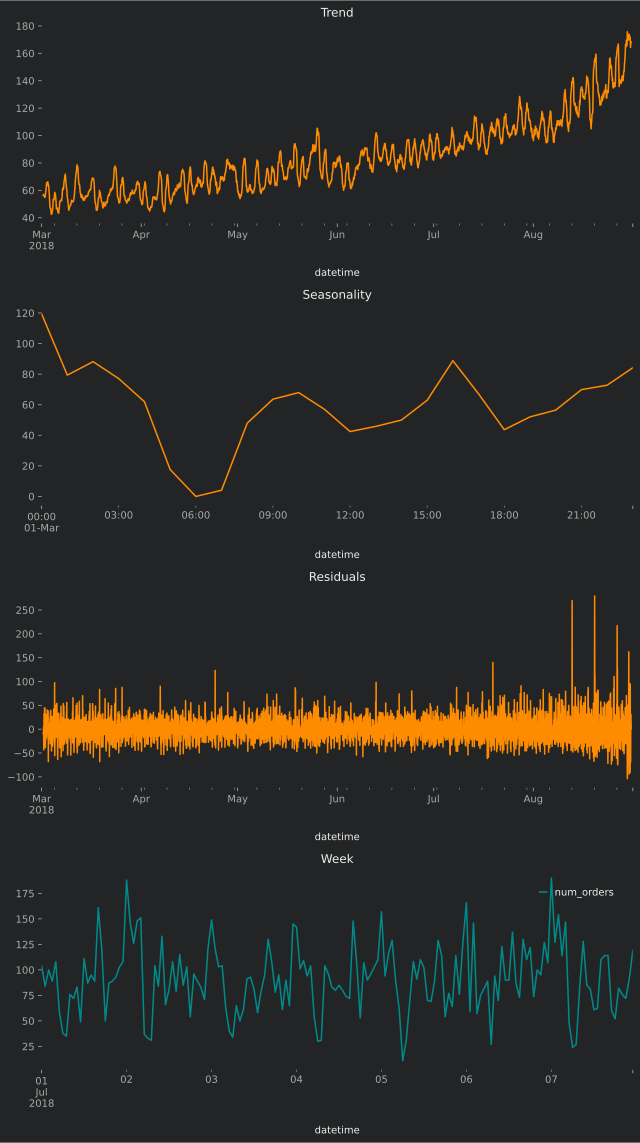

In [13]:
decomposed = seasonal_decompose(taxi_df_re)

with mpl.rc_context(custom_params):
    plt.figure(figsize=(9, 16))

    plt.subplot(411)
    decomposed.trend.plot(ax=plt.gca(), color='darkorange')
    plt.title('Trend')
    
    plt.subplot(412)
    (decomposed.seasonal['2018-03-01']
         + abs(decomposed.seasonal.min())
    ).plot(ax=plt.gca(), color='darkorange')
    plt.title('Seasonality')

    plt.subplot(413)
    decomposed.resid.plot(ax=plt.gca(), color='darkorange')
    plt.title('Residuals')
    
    plt.subplot(414)
    taxi_df_re.loc['2018-07-01': '2018-07-07'].plot(ax=plt.gca(), color='darkcyan')
    plt.title('Week')
    
    plt.tight_layout()

In [14]:
print(
    'Количество часов без вызова:',
    len(taxi_df_re.loc[taxi_df_re['num_orders'] == 0].index)
)

Количество часов без вызова: 1


Данных всего за 6 месяцев.  
Был один час когда такси не заказывали, а бывает и густо - 462 вызова за час.  
`seasonal_decompose` выявил тренд увеличения заказов к сентябрю.
`seasonal_decompose` выявил в сутках закономерность: пик вызовов в 00 часов и минимум в 6 утра.  
Похоже на правду..

<hr>

## Обучим разные модели с различными гиперпараметрами

### Создадим дополнительные признаки

In [15]:
def make_features(data, max_lag, window_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(
            window=window_size,
            closed='left',
        ).mean()

In [16]:
def create_train_test(data_df_re):
    train, test = train_test_split(data_df_re, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop(columns='num_orders')
    target_train = train['num_orders']

    features_test = test.drop(columns='num_orders')
    target_test = test['num_orders']
    
    return (features_train, target_train, features_test, target_test)

In [17]:
taxi_df_re = taxi_df.resample('1H').sum()

In [18]:
make_features(
    data=taxi_df_re,
    max_lag=7,
    window_size=4
)

### Создадим тестовую выборку

> Сделайте тестовую выборку размером размером 10% от исходных данных.

In [19]:
features_train, target_train, features_test, target_test = create_train_test(
        taxi_df_re
    )

In [20]:
cat_col = [
        'dayofweek',
        'hour',
    ]

<hr>

### Обучим LinearRegression

Подготовим OHE.

In [21]:
features_train_lin_reg = pd.get_dummies(
    features_train,
    columns=cat_col,
    drop_first=True
)

In [22]:
features_test_lin_reg = pd.get_dummies(
    features_test,
    columns=cat_col,
    drop_first=True
)

In [23]:
print(features_train_lin_reg.index.min(), features_train_lin_reg.index.max())
print(features_test_lin_reg.index.min(), features_test_lin_reg.index.max())

2018-03-01 07:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [24]:
model = LinearRegression()

In [25]:
scores_lin_reg = cross_val_score(
        model,
        features_train_lin_reg,
        target_train,
        scoring='neg_root_mean_squared_error',
        cv=7
    )

In [26]:
display(
    scores_lin_reg,
    np.median(scores_lin_reg)
)

array([-27.30888292, -21.75670987, -20.95695813, -22.44241334,
       -21.8185575 , -25.78915245, -33.5400209 ])

-22.442413339079557

In [27]:
model.fit(features_train_lin_reg, target_train)

LinearRegression()

<hr>

### Обучим CatBoostRegressor

In [28]:
taxi_df_re = taxi_df.resample('1H').sum()

In [29]:
make_features(
    data=taxi_df_re,
    max_lag=7,
    window_size=4
)

In [30]:
features_train, target_train, features_test, target_test = create_train_test(
        taxi_df_re
    )

In [31]:
after_grid = {
        'depth': 4,
        'grow_policy': 'SymmetricTree',
        'l2_leaf_reg': 5,
        'learning_rate': 0.1,
        'num_trees': 500
    }

In [32]:
cat_model = CatBoostRegressor(
        objective='RMSE',
        cat_features=cat_col,
        verbose=False,
    **after_grid
    )

In [33]:
cat_params_gs = {
        'num_trees': [500, 1000],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'grow_policy': ['SymmetricTree', 'Depthwise']
    }

`GridSearchCV` отрабатывает 1,5 часа, поэтому перевёл в `raw` чтобы не ждать..

Wall time: 1h 35min 45s

In [34]:
cat_model.fit(
    features_train,
    target_train,
)

## Проверим данные на тестовой выборке

На удивление `CatBoostRegressor` и `LinearRegression` близки по `rmse`, поэтому проверим обе модели..

In [35]:
pred_test = model.predict(features_test_lin_reg)

In [36]:
print('LinearRegression')
print(
    'RMSE тестовой выборки: {:.2f}'.format(    
        mean_squared_error(
            target_test,
            pred_test,
            squared=False,
        )
    )
)

LinearRegression
RMSE тестовой выборки: 44.85


In [37]:
cat_model_pred = cat_model.predict(
        features_test
    )

In [38]:
print('CatBoostRegressor')
print('RMSE тестовой выборки:', mean_squared_error(target_test, cat_model_pred, squared=False))

CatBoostRegressor
RMSE тестовой выборки: 45.03949948903212


<hr>

## Вывод

Загрузили данные, сгруппировали и суммировали по часам.  
Добавили сдвиги и плавающее среднее как параметры.  
Попробовали разные сдвиги и величину плавающего среднего и для каждой модели и внутри модели.  
Удивительно но `LinearRegression` и `CatBoostRegressor` показали очень близкие результаты.  
Далеко от идеала)  
Возможно, прогназировать количество вызовов такси в аэропорту целесообразней не только на основании истории вызовов. То есть имеет смысл добавить в набор данных расписание авиарейсов. Когда, откуда и какой самолёт прибыл, напимер..

>Все ли шаги по инструкции выполняете?  
Как готовите данные?  
Как анализируете данные?  
Какие модели и гиперпараметры рассматриваете?  
Не дублируете ли код?  
Какие выводы делаете?  
Следите ли за структурой проекта?  
Поддерживаете аккуратность кода?  